# PyGEM dhdt dhop

Brandon Tober<br>

31OCT2025<br><br>

This notebook demonstrated PyGEM's 2d dhdt processing functionality.
- Load a glacier directory from PyGEM's sample dataset
- Use PyGEM's shop.elevchange2d module to add any 2d dhdt data to our glacier directory
- Compute the average glacierwide mass balance


In [1]:
### imports ###
import os
import matplotlib.pyplot as plt
import xarray as xr
from IPython.display import display, JSON
from oggm import cfg, tasks, workflow
import pygem.pygem_modelsetup as modelsetup
from pygem.oggm_compat import update_cfg
from pygem.shop import elevchange2d, elevchange1d
from pygem.plot.graphics import plot_elev_change_1d
from pygem.setup.config import ConfigManager
# instantiate ConfigManager
config_manager = ConfigManager()
# read the config
pygem_prms = config_manager.read_config()   # NOTE: ensure that your root path in ~/PyGEM/config.yaml points to
                                            # the appropriate location. If any errors occur, check this first.

# set some plotting defaults
plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 8

cfg.initialize(logging_level='CRITICAL')
cfg.PATHS['working_dir'] = (
    f'{pygem_prms["root"]}/{pygem_prms["oggm"]["oggm_gdir_relpath"]}'
)

In [2]:
# initialize glacier directory
gdir = workflow.init_glacier_directories(['RGI60-01.00570'])[0];

### Process 2d dhdt data

Process 2d dhdt data to our glacier of interest. For a given single glacier directory we can run:
```{python}
elevchange.dhdt_to_gdir(gdir)
```

To run this function for many glaciers:
```{python}
workflow.execute_entity_task(elevchange.dhdt_to_gdir, gdirs)
```

In [3]:
elevchange2d.dhdt_to_gdir(gdir, verbose=True)

Found 3 files for RGI60-01.00570: ['N63W145_2000-01-01_2020-01-01_dhdt.tif', 'N63W146_2000-01-01_2020-01-01_dhdt.tif', 'N63W147_2000-01-01_2020-01-01_dhdt.tif']
Dataset time period:	2000-01-01 to 2020-01-01


Note, the example files in this sample dataset have the dtdt time period string embedded within the filenames, which `elevchange2d.dhdt_to_gdir()` tries to interpret - however, if such information is not stored within the file name, one can provide it, e.g.:

In [4]:
elevchange2d.dhdt_to_gdir(gdir, period='2000-01-01_2020-01-01', period_delimiter='_', date_format='YYYY-MM-DD', verbose=True)

Found 3 files for RGI60-01.00570: ['N63W145_2000-01-01_2020-01-01_dhdt.tif', 'N63W146_2000-01-01_2020-01-01_dhdt.tif', 'N63W147_2000-01-01_2020-01-01_dhdt.tif']
Dataset time period:	2000-01-01 to 2020-01-01


Alternatively, we could directly provide t1 and t2 strings:
```{python}
elevchange2d.dhdt_to_gdir(gdir, t1='2000-01-01', t2='2020-01-01',  date_format='YYYY-MM-DD', verbose=True)
```

In [5]:
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()
ds

<xarray.Dataset> Size: 2MB
Dimensions:          (x: 272, y: 243)
Coordinates:
  * x                (x) float32 1kB -9.163e+03 -9.094e+03 ... 9.536e+03
  * y                (y) float32 972B 7.025e+06 7.025e+06 ... 7.008e+06
Data variables:
    topo             (y, x) float32 264kB 955.9 955.2 ... 1.351e+03 1.345e+03
    topo_smoothed    (y, x) float32 264kB 960.0 961.0 ... 1.344e+03 1.34e+03
    topo_valid_mask  (y, x) int8 66kB 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask     (y, x) int8 66kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext      (y, x) int8 66kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    dhdt             (y, x) float32 264kB -2.112 -2.233 ... 0.04523 0.04043
    dhdt_1           (y, x) float32 264kB -2.112 -2.233 ... 0.04523 0.04043
    dhdt_2           (y, x) float32 264kB -1.136 -1.019 ... 0.04522 0.04042
    dhdt_3           (y, x) float32 264kB -2.989 -3.325 ... 0.04523 0.04043
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=-145.427 +k=0.9996 +x_0=0 +y_...
    max_h_dem:      2693.9072
    min_h_dem:      931.6456
    max_h_glacier:  2402.1404
    min_h_glacier:  1162.817

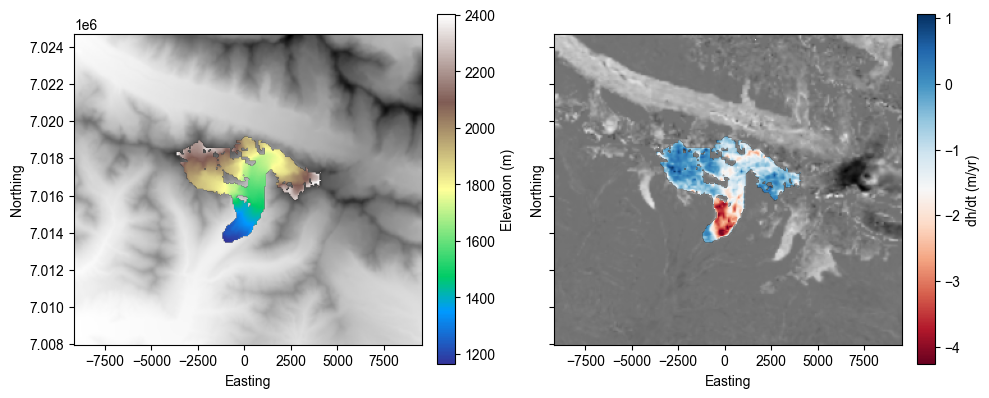

In [6]:
# plot
fig,ax  = plt.subplots(1,2,figsize=(10, 6), sharex=True, sharey=True)

# Extract coordinate names (adapt to your dataset)
x = ds.x.values 
y = ds.y.values

# Define extent = [xmin, xmax, ymin, ymax]
extent = [x.min(), x.max(), y.min(), y.max()]

ax[0].imshow(ds.topo.values, extent=extent, cmap='Greys')
im0 = ax[0].imshow(ds.topo.where(ds.glacier_mask), extent=extent, cmap='terrain')
ax[0].set_xlabel("Easting")
ax[0].set_ylabel("Northing")
# Add colorbar for topo
cbar0 = fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)
cbar0.set_label("Elevation (m)")

ax[1].imshow(ds.dhdt.values, extent=extent, cmap='Greys')
im1 = ax[1].imshow(ds.dhdt.where(ds.glacier_mask), extent=extent, cmap='RdBu')
ax[1].set_xlabel("Easting")
ax[1].set_ylabel("Northing")
# Add colorbar for dh/dt
cbar1 = fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)
cbar1.set_label("dh/dt (m/yr)")

fig.tight_layout()

### Compute glacierwide avaerage elevation change and mass balance
We can compute some statistics on the 2d dhdt data using `elevchange2d.dhdt_statistics()`:

In [7]:
elevchange2d.dhdt_statistics(gdir)

{'rgi_id': 'RGI60-01.00570',
 'rgi_region': '01',
 'rgi_subregion': '01-02',
 'rgi_area_km2': 17.567,
 'area_km2': 17.577612,
 'perc_cov': 1.0,
 'avg_dhdt': -0.9216564,
 'dmdtda': -0.8294907867908478,
 'period': '2000-01-01_2020-01-01',
 't1': '2000-01-01',
 't2': '2020-01-01'}

Viola, we have our average glacierwide mass balance from our dhdt data!

### Binning 
If we want to do this for a batch of glaciers:

```{python}
elevchange2d.compile_hugonnet_statistics(gdirs)
```

This function can also be passed a file path to store the statistics for all glaciers as a csv.

Now let's go through binning our 2d dhdt data. We can do this using OGGM's `elevation_band_flowline()` task, e.g.:

In [8]:
tasks.elevation_band_flowline(gdir,
                              bin_variables=['dhdt'],
                              )

Inspect binned dhdt data

In [9]:
import pandas as pd
df = pd.read_csv(gdir.get_filepath('elevation_band_flowline'), index_col=0)
df.head()

,area,mean_elevation,slope,dhdt,bin_elevation,dx,width
dis_along_flowline,,,,,,,
102.231392,33327.0,2345.3208,0.145686,-1.328452,2355.0,204.46278,162.997879
265.171791,114264.0,2322.2440,0.242229,-0.925008,2325.0,121.41802,941.079405
388.221779,119025.0,2290.5680,0.236124,-0.559489,2295.0,124.68196,954.628873
504.385780,295182.0,2264.3901,0.271795,-0.160982,2265.0,107.64605,2742.153580
599.405403,280899.0,2235.1914,0.349187,-0.315875,2235.0,82.39319,3409.250269


If we wish to calibrate against binned elevation change data, we need to convert from dhdt to dh and format in the structure PyGEM's `elevchange1d` module expects:

| bin_start | bin_stop | bin_area | date_start | date_end | dh | dh_sigma | ref_dem | ref_dem_year |
|------------|-----------|-----------|-------------|-----------|------|-----------|----------|---------------|
| edge0      | edge1     | area0     | date_start_1 | date_end_1 | dh_bin1_period1 | dh_sigma_bin1_period1 | ref_dem | ref_dem_year |
| edge1      | edge2     | area1     | date_start_1 | date_end_1 | dh_bin2_period1 | dh_sigma_bin2_period1 | ref_dem | ref_dem_year |
| ...        | ...       | ...       | ...         | ...       | ...  | ...       | ...      | ...           |
| edgeN-1    | edgeN     | areaN-1   | date_start_1 | date_end_1 | dh_binN-1_period1 | dh_sigma_binN-1_period1 | ref_dem | ref_dem_year |
| edge0      | edge1     | area0     | date_start_2 | date_end_2 | dh_bin1_period2 | dh_sigma_bin1_period2 | ref_dem | ref_dem_year |
| ...        | ...       | ...       | ...         | ...       | ...  | ...       | ...      | ...           |
| edgeN-1    | edgeN     | areaN-1   | date_start_M | date_end_M | dh_binN-1_periodM | dh_sigma_binN-1_periodM | ref_dem | ref_dem_year |

We can process to a format PyGEM accepts with a couple functions.

1.  `elevchange2d.dh_1d()` to bin the data as shown above and do some reformattiong (note we must provide a dhdt error).
2.  `elevchange1d.dh_1d_to_gdir()` to add the data to our glacier directory and validate the data formatting.

In [10]:
elevchange2d.dh_1d(gdir, dhdt_error=0.1)
elevchange1d.dh_1d_to_gdir(gdir)

Read the output

In [11]:
data = gdir.read_json('elev_change_1d')
display(JSON(data))

<IPython.core.display.JSON object>

Plot for a sanity check. We can use PyGEM's `graphics.plot_elev_change_1d()` function.

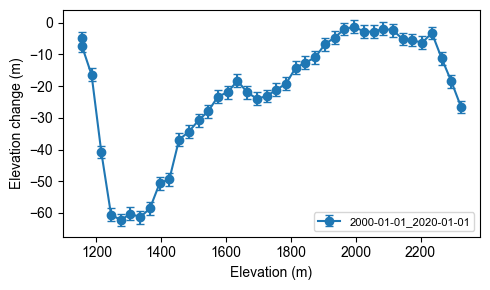

In [12]:
plot_elev_change_1d(gdir.read_json('elev_change_1d'))

### Multiple dhdt datasets?

We may potentially have multiple dhdt datasets we wish to process to a glacier directory and merge into multiple 1d elevation change records.

In [13]:
# process 2d dhdt data to gdir - specify gridded_data_suffix to keep track of different datasets
data_basedir = f'{pygem_prms["root"]}/{pygem_prms["calib"]["data"]["elev_change"]["dhdt_2d_relpath"]}/'
elevchange2d.dhdt_to_gdir(gdir, raster_path=os.path.join(data_basedir,'N63W146_2000-01-01_2020-01-01_dhdt.tif'), period_delimiter='_', gridded_data_suffix='_1', verbose=True)
elevchange2d.dhdt_to_gdir(gdir, raster_path=os.path.join(data_basedir,'2000-2005','N63W146_2000-01-01_2005-01-01_dhdt.tif'), period_delimiter='_', gridded_data_suffix='_2', verbose=True)
elevchange2d.dhdt_to_gdir(gdir, raster_path=os.path.join(data_basedir,'2015-2020','N63W146_2015-01-01_2020-01-01_dhdt.tif'), period_delimiter='_', gridded_data_suffix='_3', verbose=True)

Found 1 files for RGI60-01.00570: ['N63W146_2000-01-01_2020-01-01_dhdt.tif']
Dataset time period:	2000-01-01 to 2020-01-01
Found 1 files for RGI60-01.00570: ['N63W146_2000-01-01_2005-01-01_dhdt.tif']
Dataset time period:	2000-01-01 to 2005-01-01
Found 1 files for RGI60-01.00570: ['N63W146_2015-01-01_2020-01-01_dhdt.tif']
Dataset time period:	2015-01-01 to 2020-01-01


In [14]:
# optionally, compute statistics on each dataset - specify gridded_data_suffix to compute stats from each dataset
df1 = elevchange2d.dhdt_statistics(gdir, gridded_data_suffix='_1')
df2 = elevchange2d.dhdt_statistics(gdir, gridded_data_suffix='_2')
df3 = elevchange2d.dhdt_statistics(gdir, gridded_data_suffix='_3')
# merge the statistics dataframes
df_merged = pd.concat(map(pd.DataFrame, [[df1],[df2], [df3]]))
df_merged

,rgi_id,rgi_region,rgi_subregion,rgi_area_km2,area_km2,perc_cov,avg_dhdt,dmdtda,period,t1,t2
0,RGI60-01.00570,01,01-02,17.567,17.577612,1.0,-0.921656,-0.829491,2000-01-01_2020-01-01,2000-01-01,2020-01-01
0,RGI60-01.00570,01,01-02,17.567,17.577612,1.0,-0.686018,-0.617416,2000-01-01_2005-01-01,2000-01-01,2005-01-01
0,RGI60-01.00570,01,01-02,17.567,17.577612,1.0,-1.148302,-1.033472,2015-01-01_2020-01-01,2015-01-01,2020-01-01


In [15]:
# optionally save to csv
# df_merged.to_csv(f'{gdir.get_dir}/{'dhdt_statistics_merged.csv'})

In [16]:
# process to 1d elevation change
binneddf1 = elevchange2d.dh_1d(gdir, dhdt_error=0.1, gridded_data_suffix='_1', outfile_suffix='_1')
binneddf2 = elevchange2d.dh_1d(gdir, dhdt_error=0.1, gridded_data_suffix='_2', outfile_suffix='_2')
binneddf3 = elevchange2d.dh_1d(gdir, dhdt_error=0.1, gridded_data_suffix='_3', outfile_suffix='_3')
# concatenate arrays
merged_binneddf = pd.concat([binneddf1, binneddf2, binneddf3], axis=0)
merged_binneddf.to_csv(f'{pygem_prms["root"]}/{pygem_prms["calib"]["data"]["elev_change"]["dh_1d_relpath"]}/{(gdir.rgi_id).split('-')[1]}_elev_change_1d_merged.csv')
merged_binneddf

,bin_centers,bin_start,bin_stop,bin_area,date_start,date_end,dh,dh_sigma,ref_dem,ref_dem_year
dis_along_flowline,,,,,,,,,,
102.231392,2355.0,2370.0,2340.0,33327.0,2000-01-01,2020-01-01,-26.569044,2.000000,Copernicus DEM GLO-90,2012
265.171791,2325.0,2340.0,2310.0,114264.0,2000-01-01,2020-01-01,-18.500156,2.000000,Copernicus DEM GLO-90,2012
388.221779,2295.0,2310.0,2280.0,119025.0,2000-01-01,2020-01-01,-11.189790,2.000000,Copernicus DEM GLO-90,2012
504.385780,2265.0,2280.0,2250.0,295182.0,2000-01-01,2020-01-01,-3.219637,2.000000,Copernicus DEM GLO-90,2012
599.405403,2235.0,2250.0,2220.0,280899.0,2000-01-01,2020-01-01,-6.317510,2.000000,Copernicus DEM GLO-90,2012
...,...,...,...,...,...,...,...,...,...,...
6275.496231,1275.0,1290.0,1260.0,247572.0,2015-01-01,2020-01-01,-18.218946,0.499932,Copernicus DEM GLO-90,2012
6492.902115,1245.0,1260.0,1230.0,271377.0,2015-01-01,2020-01-01,-10.637622,0.499932,Copernicus DEM GLO-90,2012
6741.611282,1215.0,1230.0,1200.0,271377.0,2015-01-01,2020-01-01,-4.570810,0.499932,Copernicus DEM GLO-90,2012


In [17]:
# add to gdir as 1d elev change record - optionally rebin to a desired bin spacing
elevchange1d.dh_1d_to_gdir(gdir, filesuffix='_merged', bin_spacing=100)

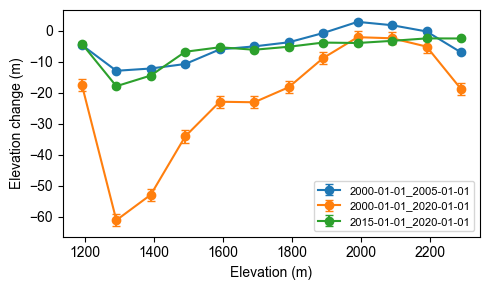

In [18]:
plot_elev_change_1d(gdir.read_json('elev_change_1d'))

Excellent, now we have a single 1d elevation change dataset added to our glacier directory. 

## Next: try a more advanced test
See, the [*advanced_test_spinup_elev_change_calib.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/advanced_test_spinup_elev_change_calib.ipynb) Jupyter Notebook for information on calibrating against binned elevation change data.